# Chap 5 서포트 벡터 머신

핸즈온 머신러닝(2판)과 [깃허브](https://github.com/codingalzi/handson-ml2/blob/master/notebooks/handson-ml2-05.ipynb)를 참고하였습니다.

> 주요 내용  
- 선형 SVM 분류  
- 비선형 SVM 분류 : 커널 트릭  
- SVM 회귀
- SVM 이론

In [1]:
# 파이썬 ≥3.5 필수
import sys
assert sys.version_info >= (3, 5) 

# 사이킷런 ≥0.20 필수
import sklearn
assert sklearn.__version__ >= "0.20"

# 공통 모듈 임포트
import numpy as np
import os

# 노트북 실행 결과를 동일하게 유지하기 위해
np.random.seed(42)

# 깔끔한 그래프 출력을 위해
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# 5.1 선형 SVM 분류 (p.205)

## 그림 5-1 라지 마진 분류

붓꽃 데이터에서 setosa 품종과 versicolor 품종만을 대상으로 선형 SVM 분류기를 학습한다.

In [2]:
from sklearn.svm import SVC
from sklearn import datasets

iris = datasets.load_iris()
X = iris['data'][:, (2,3)] # 특성 2개(꽃잎 길이, 꽃잎 너비)

In [3]:
iris['data'][:5]

array([[5.1, 3.5, 1.4, 0.2],
       [4.9, 3. , 1.4, 0.2],
       [4.7, 3.2, 1.3, 0.2],
       [4.6, 3.1, 1.5, 0.2],
       [5. , 3.6, 1.4, 0.2]])

In [4]:
y = iris['target']

setosa_or_versicolor = (y==0) | (y==1) # setosa와 versicolor만
X = X[setosa_or_versicolor]
y = y[setosa_or_versicolor]

# 선형 SVM 분류 모델
svm_clf = SVC(kernel="linear") # 하드 마진 분류
svm_clf.fit(X,y)

SVC(kernel='linear')

In [5]:
# svm_clf : 학습된 SVM 모델
# xmin, xmax : 그래프의 x축 좌표 구간
def plot_svc_decision_boundary(svm_clf, xmin, xmax):
    w = svm_clf.coef_[0]      # 결정경계 파라미터(w0, w1)
    b = svm_clf.intercept_[0] # 절편(b)

    # 결정경계에서 w0*x0 + w1*x1 + b = 0
    # => x1 = -w0/w1 * x0 - b/w1
    x0 = np.linspace(xmin, xmax, 200)
    decision_boundary = -w[0]/w[1] * x0 - b/w[1]    # 결정경계

    margin = 1/w[1]                                 # 마진(도로 폭)
    gutter_up = decision_boundary + margin          # 도로 경계(윗쪽)
    gutter_down = decision_boundary - margin        # 도로 경계(아랫쪽)

    # 서포트 벡터 표시
    svs = svm_clf.support_vectors_
    plt.scatter(svs[:, 0], svs[:, 1], s=180, facecolors='#FFAAAA')
    
    # 결정경계 및 도로 경계 그리기
    plt.plot(x0, decision_boundary, "k-", linewidth=2)
    plt.plot(x0, gutter_up, "k--", linewidth=2)
    plt.plot(x0, gutter_down, "k--", linewidth=2)

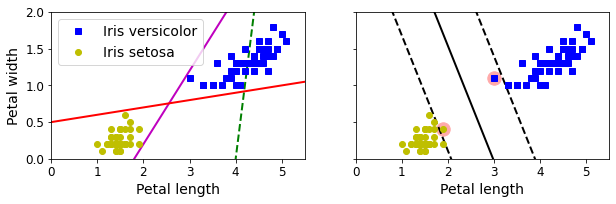

In [6]:
fig, axes = plt.subplots(ncols=2, figsize=(10,2.7), sharey=True)

# 왼쪽 그림
x0 = np.linspace(0, 5.5, 200)
pred_1 = 5*x0 - 20
pred_2 = x0 - 1.8
pred_3 = 0.1 * x0 + 0.5

plt.sca(axes[0])
plt.plot(x0, pred_1, "g--", linewidth=2)
plt.plot(x0, pred_2, "m-", linewidth=2)
plt.plot(x0, pred_3, "r-", linewidth=2)
plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", label="Iris versicolor")
plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", label="Iris setosa")
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.legend(loc="upper left", fontsize=14)
plt.axis([0, 5.5, 0, 2])

# 오른쪽 그림
plt.sca(axes[1])
plot_svc_decision_boundary(svm_clf, 0, 5.5)
plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs")
plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo")
plt.xlabel("Petal length", fontsize=14)
plt.axis([0, 5.5, 0, 2])
plt.show()

오른쪽 그래프에 있는 실선은 SVM 분류기의 결정 경계이다. 이 직선은 두 개의 클래스를 나누고 제일 가까운 훈련 샘플로부터 가능한 한 멀리 떨어져 있다. SVM 분류기를 <u>클래스 사이에 가장 폭이 넓은</u> 도로를 찾는 것이라 생각할 수 있다.
=> **라지 마진 분류**

## 서포트벡터
> 서포트 벡터 머신은 여러 집단들을 가장 잘 구분할 수 있는 최적의 선을 찾는것이 목표이다.


### 마진(Margin)
<img src="https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=https%3A%2F%2Fblog.kakaocdn.net%2Fdn%2FACb6s%2FbtqYbHJb6Nq%2FaK9i6BMHm9k62IWvDm7f21%2Fimg.png  
" width="300" height="300"/>

평행으로 그은 두 직선에 직교(직각)하는 선을 긋는다. 이것을 **마진**(Margin)이라고 하며, 마진은 두 집단 사이의 거리라고 볼 수 있는데, 이 거리가 최대로 멀수록 두 집단이 잘 분류되었다고 생각하면 된다. 이때 '거리'를 '유사도'라고 볼 수 있다. 
<br>
<br>
### 결정경계
<img src="https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=https%3A%2F%2Fblog.kakaocdn.net%2Fdn%2FbyRO9O%2FbtqYeaRPuaa%2FSVovUKDNN0RsZm5uZN6tA0%2Fimg.png" width="300" height="300"/>

두 서포트 벡터들의 중앙을 지나면서 직교(직각)하는 직선을 구한다. 이 직선은 두 집단을 분류하는 최적의 직선이며, **초평면(Hyper plane)** 또는 **결정 경계**라고 한다.
<br>
<br>
### 서포트 벡터(Support Vector)  
마진 바깥쪽에 훈련 샘플을 더 추가해도 결정 경계에 전혀 영향을 미치지 않는다. 이런 샘플을 **서포트 벡터**라 하고, `그림 5-1`에서 동그라미로 표시하였다.

---

[참고](https://bigdaheta.tistory.com/25)

## 그림 5-2 특성 스케일에 따른 민감성

<u>SVM은 특성의 스케일에 민감하다</u>. 아래 왼쪽 그래프에서는 수직축의 스케일이 수평축의 스케일보다 훨씬 커서 가장 넓은 도로가 거의 수평에 가깝게 된다. 그래서 특성의 스케일을 조정하여 오른쪽 그래프와 같이 나타내면 결정 경계가 훨씬 좋아진다. (여기서는 `StandardSCaler`사용)

(-2.0, 2.0, -2.0, 2.0)

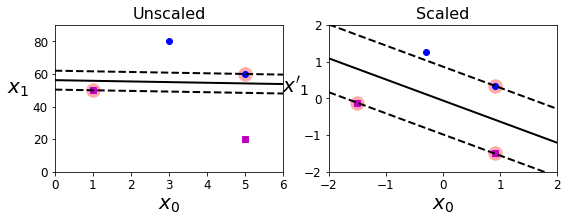

In [7]:
# 학습 데이터 4개
Xs = np.array([[1, 50], [5, 20], [3, 80], [5, 60]]).astype(np.float64)
ys = np.array([0, 0, 1, 1])

# SVM 훈련
svm_clf = SVC(kernel="linear", C=100)   # 마진 조금 허용
svm_clf.fit(Xs, ys)

# 왼편 그림
plt.figure(figsize=(9,2.7))
plt.subplot(121)
plt.plot(Xs[:, 0][ys==1], Xs[:, 1][ys==1], "bo")
plt.plot(Xs[:, 0][ys==0], Xs[:, 1][ys==0], "ms")
plot_svc_decision_boundary(svm_clf, 0, 6)
plt.xlabel("$x_0$", fontsize=20)
plt.ylabel("$x_1$    ", fontsize=20, rotation=0)
plt.title("Unscaled", fontsize=16)
plt.axis([0, 6, 0, 90])

# 오른편 그림(축척 조정 전처리 사용)
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(Xs)
svm_clf.fit(X_scaled, ys)

plt.subplot(122)
plt.plot(X_scaled[:, 0][ys==1], X_scaled[:, 1][ys==1], "bo")
plt.plot(X_scaled[:, 0][ys==0], X_scaled[:, 1][ys==0], "ms")
plot_svc_decision_boundary(svm_clf, -2, 2)
plt.xlabel("$x_0$", fontsize=20)
plt.ylabel("$x'_1$  ", fontsize=20, rotation=0)
plt.title("Scaled", fontsize=16)
plt.axis([-2, 2, -2, 2])

## 5.1.1 소프트 마진 분류 (p.206)

### 하드 마진 분류(Hard Margin Classification)  
- 모든 샘플이 경계 바깥쪽에 올바르게 분류  
- 문제점 : 데이터가 선형적으로 구분될 수 있어야 제대로 작동하며, 이상치에 민감하다.

→ 이상치(outlier)들을 허용하지 않는다. 때문에 과적합(overfitting)이 발생하기 쉽고, 노이즈로 인해 최적의 결정 경계를 잘못 구분하거나 못 찾는 경우가 발생할 수 있다. ([참고](https://bigdaheta.tistory.com/25))

---
아래는 붓꽃 데이터에 이상치 2개를 추가할 때의 SVM을 이용한 하드 마진 분류 문제를 알 수 있다.  
  
- 왼쪽 그래프 이상치 : (3,4,1.3)  
- 오른쪽 그래프 이상치 : (3.2, 0.8)  

※ 임의로 설정

In [8]:
# 이상치 두 개(꽃잎 길이, 너비)
X_outliers = np.array([[3.4, 1.3], [3.2, 0.8]])
y_outliers = np.array([0, 0])

# 왼편 그림 훈련 세트
Xo1 = np.concatenate([X, X_outliers[:1]], axis=0)
yo1 = np.concatenate([y, y_outliers[:1]], axis=0)

# 오른편 그림 훈련 세트
Xo2 = np.concatenate([X, X_outliers[1:]], axis=0)
yo2 = np.concatenate([y, y_outliers[1:]], axis=0)

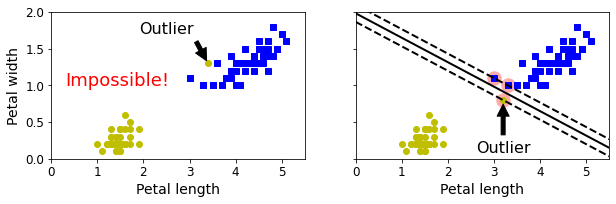

In [9]:
fig, axes = plt.subplots(ncols=2, figsize=(10,2.7), sharey=True)

# 왼편 그림: 하드 마진 분류 불가능
plt.sca(axes[0])
plt.plot(Xo1[:, 0][yo1==1], Xo1[:, 1][yo1==1], "bs")
plt.plot(Xo1[:, 0][yo1==0], Xo1[:, 1][yo1==0], "yo")
plt.text(0.3, 1.0, "Impossible!", fontsize=18, color="red")
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.annotate("Outlier",
             xy=(X_outliers[0][0], X_outliers[0][1]),
             xytext=(2.5, 1.7),
             ha="center",
             arrowprops=dict(facecolor='black', shrink=0.1),
             fontsize=16,
            )
plt.axis([0, 5.5, 0, 2])

# 오른편 그림: 좋지 않은 하드 마진 분류. SVC와 linear 커널 사용.
svm_clf2 = SVC(kernel="linear", C=10**9)     # 마진 매우 작게 설정
svm_clf2.fit(Xo2, yo2)

plt.sca(axes[1])
plt.plot(Xo2[:, 0][yo2==1], Xo2[:, 1][yo2==1], "bs")
plt.plot(Xo2[:, 0][yo2==0], Xo2[:, 1][yo2==0], "yo")
plot_svc_decision_boundary(svm_clf2, 0, 5.5)
plt.xlabel("Petal length", fontsize=14)
plt.annotate("Outlier",
             xy=(X_outliers[1][0], X_outliers[1][1]),
             xytext=(3.2, 0.08),
             ha="center",
             arrowprops=dict(facecolor='black', shrink=0.1),
             fontsize=16,
            )
plt.axis([0, 5.5, 0, 2])
plt.show()

### 소프트 마진 분류(Soft Margin Classifcation)  
하드 마진 분류의 문제를 피하기 위해 좀 더 유연한 모델이 필요하다. 소프트 마진은 이상치들을 어느 정도 허용하면서 결졍경계를 설정하는 것이다.  

- `LinearSVC` : 선형 SVM 이진 분류 모델  
     + `C=1` : 기본값, SVM 모델이 과대적합이라면 `C`를 감소시켜 모델을 규제할 수 있다.  
---
- `LinearSVC` 대신 
    + 선형 커널을 사용하는 `SVC`클래스로 대체할 수 있다. => `SVC(kernel="linear", C=1)`  
    + `SGDClassifier`을 사용할 수 있다. => `SGDClassifier(loss="hinge", alpha=1/(m*C))` (m : 샘플수)  
    
※ 참고 : LinearSVC는 `predict_proba()` 제공하지 않지만, SVC는 `probability=True`로 지정하면 `predict_proba()`를 제공한다.  

---
- 선형 SVM 분류기를 훈련하기 위해 일반적인 SGD를 적용한다. `LinearSVC`만큼 빠르게 수렴하지는 않지만 데이터셋이 크거나 온라인 학습으로 분류할 때 유용하다. 

In [10]:
## 붓꽃 데이터셋을 적재하고, 특성 스케일을 변경하고, 품종 분류를 위해 선형 SVM 모델 훈련  

import numpy as np
from sklearn import datasets
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC

iris = datasets.load_iris()
X = iris['data'][:, (2,3)] # 꽃잎 길이, 너비
y = (iris['target']==2).astype(np.float64) # Iris-Virginia

svm_clf = Pipeline([
    ("sclaer",StandardScaler()),
    ("linaer_svc",LinearSVC(C=1, loss="hinge")) # 힌지 손실
])

svm_clf.fit(X,y)

Pipeline(steps=[('sclaer', StandardScaler()),
                ('linaer_svc', LinearSVC(C=1, loss='hinge'))])

LinearSVC는 규제에 편향을 호함하여 훈련 세트에서 평균을 빼서 중앙에 맞춰야 한다. `StandardSca1er`를 사용하여 데이터 스케일을 맞추면 자동으로 이렇게 된다. 또한 <u>loss 매개변수를 "hinge"로</u> 지정해야 한다. 마지막으로 훈련 샘플보다 특성이 많지 않다연 성능을 높이기 위해 dual=False로 지정해야 한다.

In [11]:
svm_clf.predict([[5.5, 1.7]]) # Vriginia 품종으로 예측

array([1.])

### 그림 5-4 넓은 마진(왼쪽) vs 적은 마진(오른쪽)  
<img src="https://blog.kakaocdn.net/dn/uB5Zb/btqSsRpA6Qt/nzkXSq5CCMnZFeZangDnpk/img.png" height="800" width="800">  

- 왼쪽 : 마진 오류가 많지만 일반화는 잘 될 것 같다.  

# 5.2 비선형 SVM 분류 (p.209)

비선형 데이터셋을 다루는 방법은 다항 특성과 같은 특성을 더 추가하는 것이로, 이렇게 하면 선형적으로 구분되는 데이터셋이 만들어질 수 있다. 

---  
`moons` 데이터셋 : 두 개의 반원 모양으로 데이터 포인트가 놓여 있는 이진 분류를 위한 작은 데이터셋  

In [12]:
from sklearn.datasets import make_moons
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures

X, y = make_moons(n_samples=100, noise=0.15) # 데이터셋 생성
polynomial_svm_clf = Pipeline([
    ("poly_features",PolynomialFeatures(degree=3)),
    ("scaler", StandardScaler()),
    ("svm_clf",LinearSVC(C=10, loss="hinge"))
])

polynomial_svm_clf.fit(X,y)

C:\Users\dldms\Anaconda3\lib\site-packages\sklearn\svm\_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Pipeline(steps=[('poly_features', PolynomialFeatures(degree=3)),
                ('scaler', StandardScaler()),
                ('svm_clf', LinearSVC(C=10, loss='hinge'))])

**다항 특성을 사용한 선형 SVM 분류기**  

In [17]:
def plot_dataset(X, y, axes):
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "bs")
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "g^")
    plt.axis(axes)
    plt.grid(True, which='both')
    plt.xlabel(r"$x_1$", fontsize=20)
    plt.ylabel(r"$x_2$", fontsize=20, rotation=0)

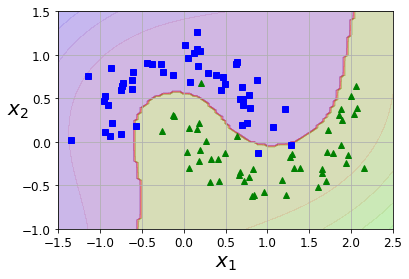

In [18]:
def plot_predictions(clf, axes):
    x0s = np.linspace(axes[0], axes[1], 100)
    x1s = np.linspace(axes[2], axes[3], 100)
    x0, x1 = np.meshgrid(x0s, x1s)
    X = np.c_[x0.ravel(), x1.ravel()]
    y_pred = clf.predict(X).reshape(x0.shape)
    y_decision = clf.decision_function(X).reshape(x0.shape)
    plt.contourf(x0, x1, y_pred, cmap=plt.cm.brg, alpha=0.2)
    plt.contourf(x0, x1, y_decision, cmap=plt.cm.brg, alpha=0.1)

plot_predictions(polynomial_svm_clf, [-1.5, 2.5, -1, 1.5])
plot_dataset(X, y, [-1.5, 2.5, -1, 1.5])

plt.show()

## 5.2.1 다항식 커널

다항식 특성을 추가하는 것은 간단하고 모든 머신러닝 알고리즘에서 잘 작동한다. 하지만 낮은 차수의 다항식은 매우 복잡한 데이터셋을 잘 표현하지 못하고 높은 차수의 다항식은 굉장히 많은 특성을 추가하므로 모델을 느리게 만든다.  

### 커널이란??  

- Kernel은 결국 두 벡터의 내적(inner product)이며, 기하학적으로 cosine 유사도를 의미하기 때문에 Similarity function 이라고도 불린다.([참고](https://velog.io/@crosstar1228/ML-kernel))
- 커널은 input space 에 존재하는 데이터들을 feature space 로 옮겨주는 역할을 한다.([참고](https://www.sallys.space/blog/2018/05/30/svm/))


In [13]:
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
poly_kernel_svm_clf = Pipeline([
    ("scaler", StandardScaler()),
    ("svm_clf", SVC(kernel="poly", degree=3, coef0=1, C=5)) # 3차
])
poly_kernel_svm_clf.fit(X,y)

Pipeline(steps=[('scaler', StandardScaler()),
                ('svm_clf', SVC(C=5, coef0=1, kernel='poly'))])

위 코드는 3차 다항식 커널을 이용해 SVM 분류기를 훈련시킨 코드이다. 적절한 차수를 정하는 게 중요한데 만약 모델이 과대적합이라면 다항식의 차수를 줄여야 하고, 과소적합이라면 차수를 늘려야 한다.  

In [14]:
poly100_kernel_svm_clf = Pipeline([
        ("scaler", StandardScaler()),
        ("svm_clf", SVC(kernel="poly", degree=10, coef0=100, C=5)) # 10차
    ])
poly100_kernel_svm_clf.fit(X, y)

Pipeline(steps=[('scaler', StandardScaler()),
                ('svm_clf', SVC(C=5, coef0=100, degree=10, kernel='poly'))])

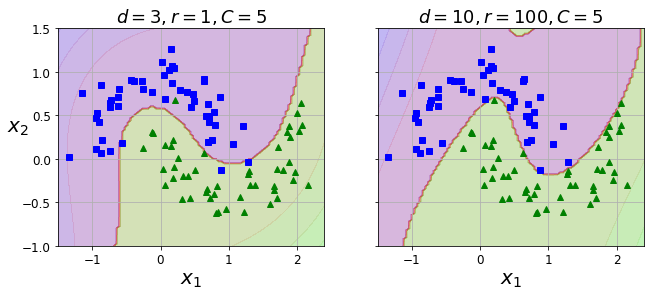

In [19]:
fig, axes = plt.subplots(ncols=2, figsize=(10.5, 4), sharey=True)

plt.sca(axes[0])
plot_predictions(poly_kernel_svm_clf, [-1.5, 2.45, -1, 1.5])
plot_dataset(X, y, [-1.5, 2.4, -1, 1.5])
plt.title(r"$d=3, r=1, C=5$", fontsize=18)

plt.sca(axes[1])
plot_predictions(poly100_kernel_svm_clf, [-1.5, 2.45, -1, 1.5])
plot_dataset(X, y, [-1.5, 2.4, -1, 1.5])
plt.title(r"$d=10, r=100, C=5$", fontsize=18)
plt.ylabel("")

plt.show()

## 5.2.2 유사도 특성

각 샘플이 특정 랜드마크와 얼마나 닮았는지 측정하는 **유사도 함수**로 계산한 특성을 추가할 수도 있다. 


랜드마크를 선택하기 위한 간단한 방법은 데이터셋에 있는 모든 샘플 위치에 랜드마크를 설정하는 것이다.
이 방법은 다음과 같은 특징을 가진다.  
    - 차원이 매우 커져 변환된 훈련 세트가 선형적으로 구분될 가능성이 높다.  
    - 훈련 세트에 있는 n개의 특성을 가진 m개의 샘플 → m개의 특성을 가진 m개의 샘플로 변환  
    - 훈련 세트가 매우 크면 동일한 크기의 특성이 많아진다.  

## 5.2.3 가우시안 RBF 커널

다항 특성을 추가해서 훈련하게 되면 비용이 경우에 따라 비쌀 수 있다. 하지만 SVM은 커널트릭(kernel trick)을 사용해 실제로 특성을 추가하지 않아도 특성을 추가한 효과를 얻을 수 있다.  

다음은 가우시안 RBF 커널을 사용한 SVC 모델이다.  

---
※ 여러 가지 커널 중 먼저 선형 커널(`LinearSVC`)을 시도하고, 훈련 세트가 너무 크지 않으면 가우시안 RBF 커널 시도도 좋다.  

In [21]:
rbf_kernel_svm_clf = Pipeline([
    ("scaler", StandardScaler()),
    ("svm_clf",SVC(kernel="rbf", gamma=5, C=0.001))
])
rbf_kernel_svm_clf.fit(X,y) # 아래 그림에서 왼쪽 아래에 해당

Pipeline(steps=[('scaler', StandardScaler()),
                ('svm_clf', SVC(C=0.001, gamma=5))])

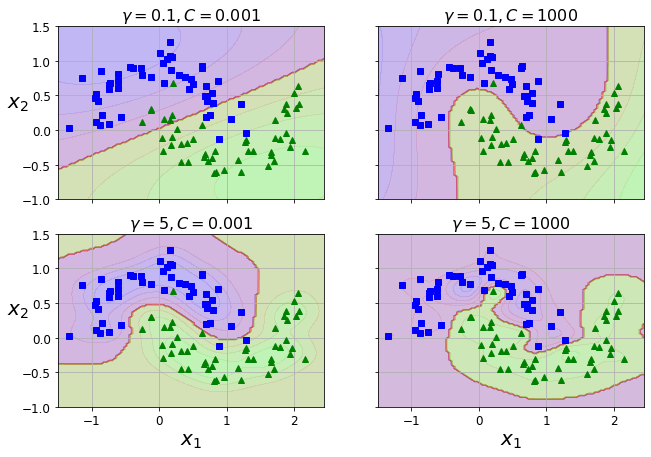

In [22]:
from sklearn.svm import SVC

gamma1, gamma2 = 0.1, 5
C1, C2 = 0.001, 1000
hyperparams = (gamma1, C1), (gamma1, C2), (gamma2, C1), (gamma2, C2)

svm_clfs = []
for gamma, C in hyperparams:
    rbf_kernel_svm_clf = Pipeline([
            ("scaler", StandardScaler()),
            ("svm_clf", SVC(kernel="rbf", gamma=gamma, C=C))
        ])
    rbf_kernel_svm_clf.fit(X, y)
    svm_clfs.append(rbf_kernel_svm_clf)

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10.5, 7), sharex=True, sharey=True)

for i, svm_clf in enumerate(svm_clfs):
    plt.sca(axes[i // 2, i % 2])
    plot_predictions(svm_clf, [-1.5, 2.45, -1, 1.5])
    plot_dataset(X, y, [-1.5, 2.45, -1, 1.5])
    gamma, C = hyperparams[i]
    plt.title(r"$\gamma = {}, C = {}$".format(gamma, C), fontsize=16)
    if i in (0, 1):
        plt.xlabel("")
    if i in (1, 3):
        plt.ylabel("")

plt.show()

- `gamma`가 커지면 종 모양 그래프가 좁아져 각 샘플의 영향 범위가 작아진다. 또한 결정 경계가 불규칙해지고 각 샘플을 따라 구불구불하게 휘어진다. 
- `gamma`가 작으면 종 모양 그래프가 커져 샘플의 영향 범위가 넓어 결정 경계가 더 부드러워진다. 결국 $\gamma$가 규제 역할을 하여 모델이 과대적합일 땐 $\gamma$를 감소시키고 과소적합일 경우 증가시킨다.  

## 5.2.4 계산 복잡도

- `LinearSVC` 클래스는 선형 SVM을 위한 최적화된 알고리즘을 구현한 `liblinear` 라이브러리를 기반으로 한다. 커널 트릭을 지원하지 않지만 훈련 샘플과 특성 수에 거의 선형적으로 늘어난다. => $O(m×n)$  
- `SVC`는 커널 트릭 알고리즘을 구현한 `libsvm` 라이브러리를 기반으로 한다. 훈련 샘플 수가 커지면 매우 느려진다. 훈련 샘플 수가 작은 경우 잘 맞는다. 특성의 개수에는 특히 희소특성(각 샘플에 0이 아닌 특성이 몇 개 없는 경우)인 경우에는 잘 확장된다. 이 경우 알고리즘의 성능이 특성의 평균 수에 비례한다. => $O(m^2×n)$과 $O(m^3×n)$ 사이  

# 5.3 SVM 회귀 (p.217)

SVM은 선형, 비선형 분류 뿐만 아니라 <u>선형, 비선형 회귀</u>에도 사용할 수 있다. 이를 `SVM 회귀`라고 지칭하는데, SVM 회귀는 제한된 마진 오류 안에서 도로 안에 가능한 한 많은 샘플이 들어가도록 학습한다. 마진 오류의 폭은 하이퍼파라미터 $\epsilon$으로 조절한다. 그리고 이 모델은 마진 안에서 훈련 샘플이 추가되어도 모델 예측에 영향을 주지 않기 떄문에 $\epsilon$에 민감하지 않다.  

※ SVM을 이상치 탐지에서도 사용할 수 있다.

In [24]:
np.random.seed(42)
m = 50
X = 2 * np.random.rand(m, 1)
y = (4 + 3 * X + np.random.randn(m, 1)).ravel()

In [26]:
svm_reg1 = LinearSVR(epsilon=1.5, random_state=42)
svm_reg2 = LinearSVR(epsilon=0.5, random_state=42)
svm_reg1.fit(X, y)
svm_reg2.fit(X, y)

def find_support_vectors(svm_reg, X, y):
    y_pred = svm_reg.predict(X)
    off_margin = (np.abs(y - y_pred) >= svm_reg.epsilon)
    return np.argwhere(off_margin)

svm_reg1.support_ = find_support_vectors(svm_reg1, X, y)
svm_reg2.support_ = find_support_vectors(svm_reg2, X, y)

eps_x1 = 1
eps_y_pred = svm_reg1.predict([[eps_x1]])

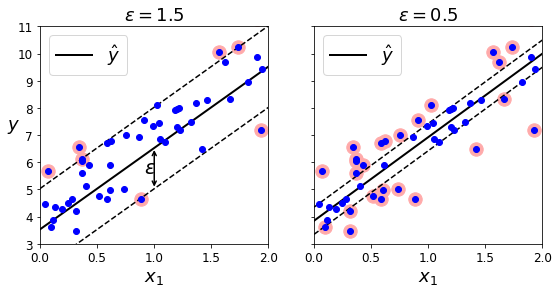

In [27]:
def plot_svm_regression(svm_reg, X, y, axes):
    x1s = np.linspace(axes[0], axes[1], 100).reshape(100, 1)
    y_pred = svm_reg.predict(x1s)
    plt.plot(x1s, y_pred, "k-", linewidth=2, label=r"$\hat{y}$")
    plt.plot(x1s, y_pred + svm_reg.epsilon, "k--")
    plt.plot(x1s, y_pred - svm_reg.epsilon, "k--")
    plt.scatter(X[svm_reg.support_], y[svm_reg.support_], s=180, facecolors='#FFAAAA')
    plt.plot(X, y, "bo")
    plt.xlabel(r"$x_1$", fontsize=18)
    plt.legend(loc="upper left", fontsize=18)
    plt.axis(axes)

fig, axes = plt.subplots(ncols=2, figsize=(9, 4), sharey=True)
plt.sca(axes[0])
plot_svm_regression(svm_reg1, X, y, [0, 2, 3, 11])
plt.title(r"$\epsilon = {}$".format(svm_reg1.epsilon), fontsize=18)
plt.ylabel(r"$y$", fontsize=18, rotation=0)
plt.annotate(
        '', xy=(eps_x1, eps_y_pred), xycoords='data',
        xytext=(eps_x1, eps_y_pred - svm_reg1.epsilon),
        textcoords='data', arrowprops={'arrowstyle': '<->', 'linewidth': 1.5}
    )
plt.text(0.91, 5.6, r"$\epsilon$", fontsize=20)
plt.sca(axes[1])
plot_svm_regression(svm_reg2, X, y, [0, 2, 3, 11])
plt.title(r"$\epsilon = {}$".format(svm_reg2.epsilon), fontsize=18)
plt.show()

In [32]:
from sklearn.svm import LinearSVR

svm_reg = LinearSVR(epsilon=1.5)
svm_reg.fit(X,y)

LinearSVR(epsilon=1.5)

In [35]:
np.random.seed(42)
m = 100
X = 2 * np.random.rand(m, 1) - 1
y = (0.2 + 0.1 * X + 0.5 * X**2 + np.random.randn(m, 1)/10).ravel()

In [36]:
from sklearn.svm import SVR

svm_poly_reg1 = SVR(kernel="poly", degree=2, C=100, epsilon=0.1, gamma="scale")
svm_poly_reg2 = SVR(kernel="poly", degree=2, C=0.01, epsilon=0.1, gamma="scale")
svm_poly_reg1.fit(X, y)
svm_poly_reg2.fit(X, y)

SVR(C=0.01, degree=2, kernel='poly')

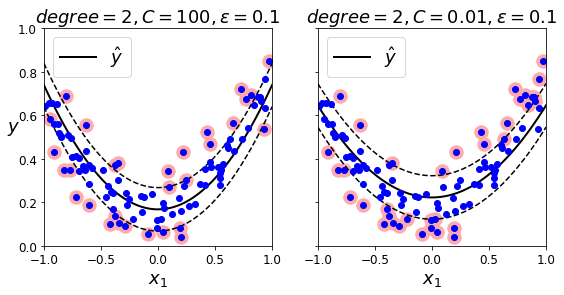

In [37]:
fig, axes = plt.subplots(ncols=2, figsize=(9, 4), sharey=True)
plt.sca(axes[0])
plot_svm_regression(svm_poly_reg1, X, y, [-1, 1, 0, 1])
plt.title(r"$degree={}, C={}, \epsilon = {}$".format(svm_poly_reg1.degree, svm_poly_reg1.C, svm_poly_reg1.epsilon), fontsize=18)
plt.ylabel(r"$y$", fontsize=18, rotation=0)
plt.sca(axes[1])
plot_svm_regression(svm_poly_reg2, X, y, [-1, 1, 0, 1])
plt.title(r"$degree={}, C={}, \epsilon = {}$".format(svm_poly_reg2.degree, svm_poly_reg2.C, svm_poly_reg2.epsilon), fontsize=18)
plt.show()

위 그래프는 임의의 2차방정식 형태의 훈련 세트에 2차 다항 커널(degree=2)을 사용한 SVM 회귀를 보여준다.   
    - 왼쪽 : 규제가 거의 없음(C가 매우 큼)   
    - 오른쪽 : 규제가 훨씬 많은(C가 작음)  

In [40]:
from sklearn.svm import SVR 
svm_poly_reg = SVR(kernel="poly" , degree=2, C=100, epsilon=0.1) # SVMC의 회귀 버전
svm_poly_reg.fit(X, y)

SVR(C=100, degree=2, kernel='poly')

`LinearSVR`(LinearSVC처럼)은 훈련 세트 크기가 커지면 비례해서 시간이 선형적으로 비례해 필요하지만, `SVR`(SVC처럼)은 훈련 세트가 커지면 훨씬 느려진다.  

# 5.4 SVM 이론 (p.219) 

## 5.4.1 결정 함수와 예측

## 5.4.2 목적 함수

## 5.4.3 콰트라틱 프로그래밍

## 5.4.4 쌍대 문제

## 5.4.5 커널 SVM

## 5.4.6 온라인 SVM